In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 浮点ema
def ema_float_1st(x, alpha):
    y = x.copy().astype(np.float32)
    y_new = np.zeros_like(y)
    y_new[0] = 0.5*alpha * y[0]
    for n in range(1, len(y)):
        y_new[n] = 0.5* alpha * y[n] + 0.5* alpha * y[n-1] + (1 - alpha) * y_new[n - 1]
    y = y_new
    return y

# 浮点级联ema
def ema_float_cascade_2nd(x, alpha_list):
    y = x.copy().astype(np.float32)
    for alpha in alpha_list:
        y_new = np.zeros_like(y)
        y_new[0] = 0.5*alpha * y[0]
        for n in range(1, len(y)):
            y_new[n] = 0.5* alpha * y[n] + 0.5* alpha * y[n-1] + (1 - alpha) * y_new[n - 1]
        y = y_new
        # print(alpha)
        # print(y[:10])
    return y

# 定点ema
def ema_fixed_1st(x, alpha, frac_bits=7):
    # get params
    n1 = np.abs(np.log2(alpha)).astype(np.int32),
    # print(n1, n2)
    # 1nd
    y = x.copy().astype(np.int32)
    y_new = np.zeros_like(y)
    y_new[0] = y[0] << frac_bits >> n1
    for n in range(1, len(y)):
        # y_new[n] = (alpha_list[0] * (y[n] + y[n-1]) >> frac_bits) + ((1 << frac_bits) - alpha_list[0]) * y_new[n - 1] >> frac_bits
        y_new[n] = ((((y[n] + y[n-1]) << frac_bits) - y_new[n - 1]) >> n1) + y_new[n - 1]
    y = y_new >> (frac_bits+1)
    # y = y_new.astype(np.float32) / (2**(frac_bits+1))
    return y.astype(np.float32)

# 定点级联ema
def ema_fixed_cascade(x, alpha_list, frac_bits=8):
    # get params
    n1, n2 = np.abs(np.log2(alpha_list[0])).astype(np.int32), np.abs(np.log2(alpha_list[1])).astype(np.int32)
    # print(n1, n2)
    # 1nd
    y = x.copy().astype(np.int32)
    y_new = np.zeros_like(y)
    y_new[0] = y[0] << frac_bits >> n1
    for n in range(1, len(y)):
        # y_new[n] = (alpha_list[0] * (y[n] + y[n-1]) >> frac_bits) + ((1 << frac_bits) - alpha_list[0]) * y_new[n - 1] >> frac_bits
        y_new[n] = ((((y[n] + y[n-1]) << frac_bits) - y_new[n - 1]) >> n1) + y_new[n - 1]
    y = y_new
    print("fixed 1st stage output: ")
    print(y[:10])
    # 2nd
    y_new = np.zeros_like(y)
    y_new[0] = y[0] >> 1 >> n2
    for n in range(1, len(y)):
        # version 1
        # y_new[n] = (((y[n]>> 1) + (y[n-1]>> 1)  - y_new[n - 1]) >> n2) + y_new[n - 1]
        y_new[n] = ((((y[n] + y[n-1])>> 1)  - y_new[n - 1]) >> n2) + y_new[n - 1]
    # print("fixed 2nd stage output: ")
    # print(y[:10])

    y = y_new >> (frac_bits+1)

    # print("fixed 2nd stage output, rigth shift: ")
    # print(y[:10])
    return y.astype(np.float32)

In [3]:
# 测试序列生成
def signal_generator(fs, time, signal_range, start_freq, end_freq):
    """
    生成一个持续仿真时间的每秒频率递增的正弦波信号。
    参数：
    fs - 每秒采样点数
    time - 仿真时间（秒）
    signal_range - 信号幅度范围
    start_freq - 起始频率(Hz)
    end_freq - 终止频率(Hz)
    
    返回：
    generated_signal - 生成的信号
    """
    num_samples = fs * time  # 总样本数
    t = np.linspace(0, time, num_samples, endpoint=False)  # 时间序列
    generated_signal = np.zeros_like(t)  # 初始化信号数组

    # 逐秒递增频率，生成正弦波信号
    for i in range(time):
        freq = start_freq + i * (end_freq - start_freq) / time
        samples_per_cycle = fs / freq  # 每个周期的样本数
        num_cycles = int(fs // samples_per_cycle)  # 每秒能容纳的完整周期数

        if num_cycles >= 1:
            cycle_samples = int(num_cycles * samples_per_cycle)  # 完整周期的样本数
            t_segment = np.linspace(0, cycle_samples / fs, cycle_samples, endpoint=False)  # 当前段的时间序列
            sine_segment = np.sin(2 * np.pi * freq * t_segment)  # 生成当前频率的正弦波
            generated_signal[i * fs : i * fs + cycle_samples] = np.round(sine_segment * signal_range)  # 插入信号

    return generated_signal

fixed 1st stage output: 
[   0   84  321  692 1181 1773 2459 3223 4056 4949]


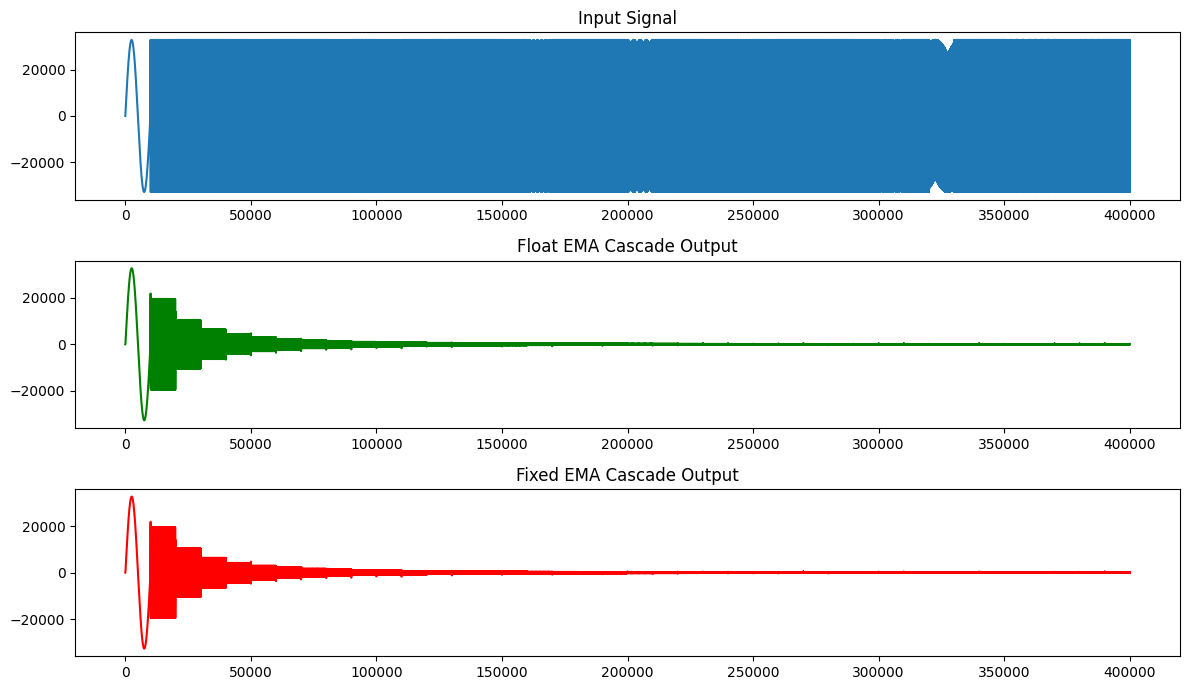

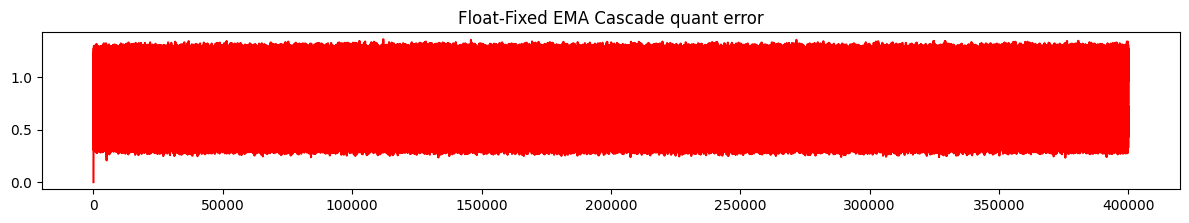

Average Quantization Error: 0.7935888


In [4]:
# 生成一个从start_freq(Hz)到end_freq(Hz)的正弦波信号，1s一个频率段
start_freq = 1      # 起始频率
end_freq = 2500     # 终止频率
fs = 10000  # 每秒采样点数
time = 40  # 仿真时间
signal_range = 32767
x = signal_generator(fs, time, signal_range, start_freq, end_freq)

alpha = [0.5**3, 0.5**5]

# print("input x: ", x[:10])
y_float = ema_float_cascade_2nd(x, alpha)
y_fixed = ema_fixed_cascade(x, alpha, 5)

# 一阶的量化误差分析测试
# y_float = ema_float_1st(x, alpha[0])
# y_fixed = ema_fixed_1st(x, alpha[0], 8)

# 绘图比较
plt.figure(figsize=(12, 7))
plt.subplot(3, 1, 1)
plt.plot(x, label='Input Signal')
plt.title('Input Signal')
plt.subplot(3, 1, 2)
plt.plot(y_float, label='Float EMA Cascade', color='g')
plt.title('Float EMA Cascade Output')
plt.subplot(3, 1, 3)
plt.plot(y_fixed, label='Fixed EMA Cascade', color='r')
plt.title('Fixed EMA Cascade Output')
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 3)
plt.plot(np.abs(y_float-y_fixed), label='quane error', color='r')
plt.title('Float-Fixed EMA Cascade quant error')
plt.tight_layout()
plt.show()

print("Average Quantization Error:", np.mean(np.abs(y_float - y_fixed)))

# print(y_float[:10])

# print(x[:10])
# print(y_fixed[:10])

# for i in range(6):
#     for j in range(6):
#         if i <= j:
#             alpha = [0.5**i, 0.5**j]
#             y_float = ema_float_cascade_2nd(x, alpha)
#             y_fixed = ema_fixed_cascade(x, alpha)
#             error = np.mean(np.abs(y_float - y_fixed))
#             print(f"Alpha: [{alpha[0]:.5f}, {alpha[1]:.5f}] - Average Quantization Error: {error:.5f}")



In [5]:
# rtl compare
alpha_list = [0.5, 0.5]
x = [100 for _ in range(100)]
y = ema_fixed_cascade(np.array(x), alpha_list, frac_bits=7)
print(y)

fixed 1st stage output: 
[ 6400 16000 20800 23200 24400 25000 25300 25450 25525 25562]
[ 6. 25. 48. 67. 80. 88. 93. 96. 97. 98. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.]
